In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
np.random.seed(99)

In [3]:
Sigma_dyn_list = np.array([0,1e-12,1e-10,1e-8,1e-6,1e-4,1e-3,5e-3,
                           1e-2,5e-2,1e-1,2e-1,4e-1,6e-1,8e-1,1,1.2,1.4])
var_list = Sigma_dyn_list

In [4]:
%run ./Lorenz_data.ipynb
%run ./ESN.ipynb
%run ./Reconstruct.ipynb

N_washout = 100
N_train   = 10000
N_tstart  = 10000
N_test    = 3000

Scenario1 = [[0,1], [2,1], [3,2]] # 0←1→2→3
Scenario2 = [[0,2], [2,1], [1,0], [0,3], [4,2]]# 0←2←1←0, 3→0, 2→4
Scenarios = [Scenario1,Scenario2]

A_S = []
for s in Scenarios:
    N_x = np.max(np.array(s)) + 1
    A = np.zeros((N_x, N_x))
    for ij in s:
        i,j=ij[0],ij[1]
        A[i,j] = 1
    A_S.append(A)

sigma_obs = 1e-3

In [ ]:
TDI_A = []
N_data = 10

for A in A_S:
    scenario_start = time.time()
    N_x = A.shape[0]
    
    N_net = 5
    TDI_var = np.zeros((N_net, len(var_list), N_data, N_x, N_x))
    for var_index in range(len(var_list)):
        sigma_dyn = var_list[var_index]
        for data_index in range(N_data):
            X = gen_data_norm(N_x, A, N_tstart+N_test, sigma_dyn = sigma_dyn, sigma_obs = sigma_obs)
            # washout
            X_washout = X[:N_washout]
            # training
            X_t = X[N_washout:N_washout+N_train-1]
            Y_t = X[N_washout+1:N_washout+N_train]

            X_test = X[N_tstart:]

            variables = np.arange(N_x)+1

            N_dim   = 3 * N_x # dimension of inputs (and outputs)
            N_units = 100 * N_dim #units in the reservoir 

            for net in range(N_net):
                esn = ESN(N_units, N_dim, N_dim)
                esn.train(X_washout, X_t, Y_t)

                N_rep, N_evo = 25, 7
                TDI_var[net, var_index, data_index, :, :] = cal_TDI(esn, X_test, N_x, 3, 0, 1, N_rep, N_washout, N_evo, j_threshold = 0.05)

    TDI = np.mean(TDI_var, axis=0)
    TDI_A.append(TDI)
    
    print(f'scenario finish, runtime={time.time() - scenario_start :.2f}')

scenario finish, runtime=11175.10
scenario finish, runtime=29680.46


In [9]:
%run ./Plot_TDI.ipynb

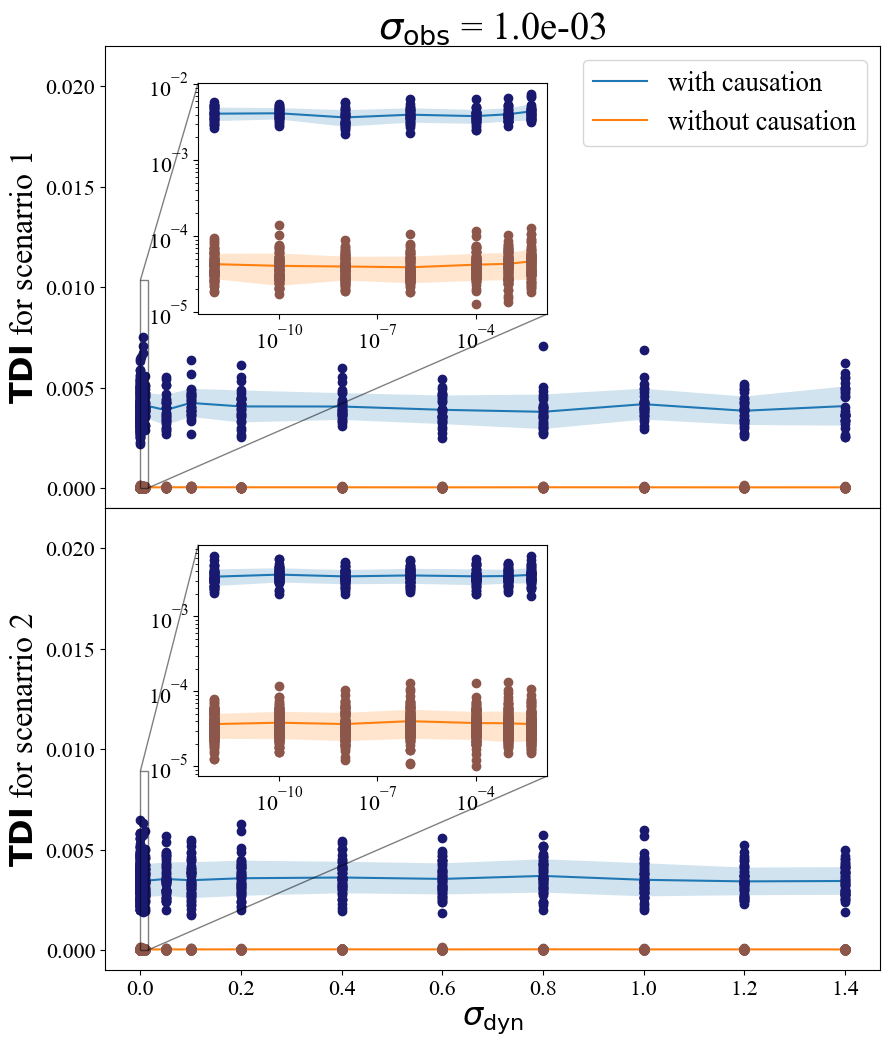

In [11]:
various_TDI_categorized = []
strength_list = [1,0]

for st_index in range(len(strength_list)):
    various_TDI_categorized.append([])
    for sc_index in range(len(A_S)):
        N_links = []
        A = A_S[sc_index]
        for s in strength_list:
            N_links.append(len(np.where(A == s)[0]))
        N_links[1] -= len(A)
        various_TDI_categorized[st_index].append(np.zeros((len(var_list), N_links[st_index] * N_data)))

for sc_index in range(len(Scenarios)):
    A = A_S[sc_index]
    for var_index in range(len(var_list)):
        TDIs = TDI_A[sc_index][var_index,:,:,:]
        TDI_cat = get_TDI_categorized(TDIs, A, strength_list)
        for st_index in range(len(strength_list)):
            various_TDI_categorized[st_index][sc_index][var_index, :] = np.array(TDI_cat[st_index])

xlabel = '$\sigma_\mathrm{dyn}$'
title = '$\sigma_\mathrm{obs}$ = '+f'{sigma_obs:.1e}'
filename = 'various_sigma_dyn'
axins_pos = [0.12, 0.42, 0.45, 0.5]
xscale_log_inset = True
yscale_log_inset = True
inset_show_list = [1,2,3,4,5,6,7]
zoom_inset_settings = (axins_pos, xscale_log_inset, yscale_log_inset, inset_show_list) 
ylim = [[-0.001, 0.022], [-0.001, 0.022]]

plot_various(len(Scenarios), various_list = var_list, various_TDI_categorized = various_TDI_categorized, strength_list=strength_list,
             filename = filename, title = title, xscale_log = False, ylim = ylim, 
             legend_loc = 'upper right', xlabel = xlabel, x_ticks = None, zoom_inset_settings = zoom_inset_settings)